In [19]:
# # Notebook de Classificação com Grid Search e Avaliação de Modelos

# ## 1. Importação das Bibliotecas Necessárias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV,RepeatedKFold,cross_val_score,cross_validate
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRFRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from ucimlrepo import fetch_ucirepo
from sklearn.metrics import root_mean_squared_error,mean_squared_error,r2_score
from datetime import datetime
from sklearn.compose import TransformedTargetRegressor
import warnings
warnings.filterwarnings("ignore")

In [2]:
file_prefix= "wine"

###  Lendos Dataset

In [3]:
# fetch dataset 
wine_quality = fetch_ucirepo(id=186) 
  
# data (as pandas dataframes) 
X = wine_quality.data.features 
y = wine_quality.data.targets 
  
# metadata 
print(wine_quality.metadata) 
  
# variable information 
print(wine_quality.variables) 

{'uci_id': 186, 'name': 'Wine Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/186/wine+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/186/data.csv', 'abstract': 'Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests (see [Cortez et al., 2009], http://www3.dsi.uminho.pt/pcortez/wine/).', 'area': 'Business', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 4898, 'num_features': 11, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['quality'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Wed Nov 15 2023', 'dataset_doi': '10.24432/C56S3T', 'creators': ['Paulo Cortez', 'A. Cerdeira', 'F. Almeida', 'T. Matos', 'J. Reis'], 'intro_paper': {'title': 'Modeling wine preferences by data mining from physicoc

In [4]:
X.head(5)

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  
0      9.4  
1      9.8  
2      9.8  
3      9.8  
4      9.4

In [5]:
y.head(5)


quality
0        5
1        5
2        5
3        6
4        5

### Pré-Processamento

In [7]:
y["quality"].unique()

array([5, 6, 7, 4, 8, 3, 9], dtype=int64)

<Axes: ylabel='Count'>

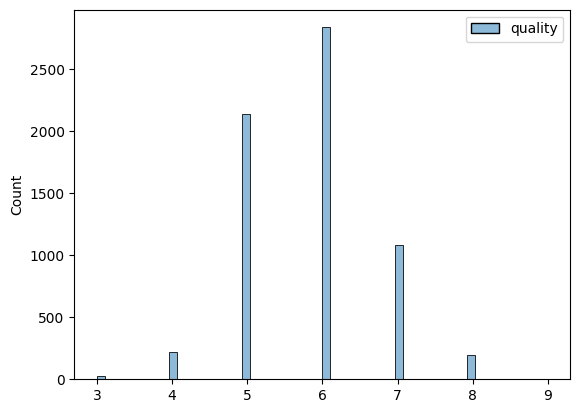

In [8]:
sns.histplot(y)

### Separando em treino  e teste

In [9]:

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


### Definindo os valores para o Grid Search

In [15]:

n_estimatores = [ i for i in range(10,121,20)]
max_depth = [4,6,8,10,None]
learning_rate = [round((1/(i)),5) for i in range(10,500,100)]

# ## 3. Definição dos Modelos e Parâmetros para Grid Search
# - Definir os parâmetros de busca para cada um dos modelos

# Definindo os parâmetros para cada modelo
param_grid_xgb = {
    'regressor__learning_rate': learning_rate,
    'regressor__max_depth': max_depth,
    'regressor__n_estimators': n_estimatores
}

param_grid_lgb = {
    'regressor__learning_rate': learning_rate,
    'regressor__max_depth': max_depth,
    'regressor__n_estimators': n_estimatores
}

param_grid_cat = {
    'regressor__learning_rate': learning_rate,
    'regressor__depth': max_depth,
    'regressor__iterations': n_estimatores
}

param_grid_gb = {
    'regressor__learning_rate': learning_rate,
    'regressor__max_depth': max_depth,
    'regressor__n_estimators': n_estimatores
}


In [12]:

def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        total_time_seconds =(datetime.now() - start_time).total_seconds()
        thour, temp_sec = divmod(total_time_seconds, 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))
        
        return total_time_seconds
    

In [24]:

xgb = TransformedTargetRegressor(XGBRFRegressor(objective='binary:logistic', nthread=1),
                                 transformer=MinMaxScaler(feature_range=(0,1)))

# Aplicando Grid Search para cada modelo
print("Iniciando Grid Search para XGBoost...")
grid_search_xgb = GridSearchCV(xgb, param_grid_xgb,cv=10,scoring="neg_root_mean_squared_error" 
                               #,verbose=3
                               )

tot_time = timer()
grid_search_xgb.fit(X_train,y_train)
time_grid_search_xgb = timer(tot_time)
print(time_grid_search_xgb)

print(f"best parameter:{grid_search_xgb.best_params_} - best score:{grid_search_xgb.best_score_}")

best_xgb = grid_search_xgb.best_params_


Iniciando Grid Search para XGBoost...

 Time taken: 0 hours 3 minutes and 21.42 seconds.
201.418367
best parameter:{'regressor__learning_rate': 0.1, 'regressor__max_depth': 10, 'regressor__n_estimators': 110} - best score:-0.8448060020197478


In [27]:

lgb =TransformedTargetRegressor(LGBMRegressor(objective="binary",n_jobs=1,verbose=0),
                                 transformer=MinMaxScaler(feature_range=(0,1)))

grid_search_lgb = GridSearchCV(lgb, param_grid_lgb,cv=10,scoring="neg_root_mean_squared_error"
                               #,verbose=3
                               )

tot_time = timer()
grid_search_lgb.fit(X_train,y_train)
time_grid_search_lgb = timer(tot_time)
print(time_grid_search_lgb)

print(f"best parameter:{grid_search_lgb.best_params_} - best score:{grid_search_lgb.best_score_}")

best_lgb = grid_search_lgb.best_params_


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [28]:


print("Iniciando Grid Search para CatBoost...")
cat =TransformedTargetRegressor(CatBoostRegressor(logging_level="Silent"),
                                 transformer=MinMaxScaler(feature_range=(0,1)))

grid_search_cat = GridSearchCV(cat, param_grid_cat,cv=10,scoring="neg_root_mean_squared_error"
                               #,verbose=3
                               )

tot_time = timer()
grid_search_cat.fit(X_train,y_train)
time_grid_search_cat = timer(tot_time)
print(time_grid_search_cat)

print(f"best parameter:{grid_search_cat.best_params_} - best score:{grid_search_cat.best_score_}")

best_cat = grid_search_cat.best_params_


Iniciando Grid Search para CatBoost...

 Time taken: 0 hours 6 minutes and 42.58 seconds.
402.582718
best parameter:{'regressor__depth': 10, 'regressor__iterations': 110, 'regressor__learning_rate': 0.1} - best score:-0.6538047658254608


In [29]:


print("Iniciando Grid Search para Gradient Boosting...")
gb =TransformedTargetRegressor(GradientBoostingRegressor(),
                                 transformer=MinMaxScaler(feature_range=(0,1)))

grid_search_gb = GridSearchCV(gb, param_grid_gb,cv=10,scoring="neg_root_mean_squared_error"
                              #,verbose=3
                              )

tot_time = timer()
grid_search_gb.fit(X_train,y_train)
time_grid_search_gb = timer(tot_time)
print(time_grid_search_gb)

print(f"best parameter:{grid_search_gb.best_params_} - best score:{grid_search_gb.best_score_}")

best_gb = grid_search_gb.best_params_

Iniciando Grid Search para Gradient Boosting...

 Time taken: 0 hours 23 minutes and 0.05 seconds.
1380.051574
best parameter:{'regressor__learning_rate': 0.1, 'regressor__max_depth': 8, 'regressor__n_estimators': 110} - best score:-0.6358840478230173


In [30]:
best_parameters =pd.DataFrame(index=["xgb","lgb","cat","gb"],data=[best_xgb,best_lgb,best_cat,best_gb])
best_parameters.to_csv(path_or_buf=f"best_parameters_{file_prefix}.csv",sep=",")



In [31]:
time_grid_search = best_parameters =pd.DataFrame(index=["xgb","lgb","cat","gb"],data=[time_grid_search_xgb,time_grid_search_lgb,time_grid_search_cat,time_grid_search_gb])
time_grid_search.to_csv(path_or_buf=f"time_{file_prefix}.csv",sep=",")


In [32]:
best_parameters =pd.read_csv("best_parameters_cancer.csv",sep=",",index_col=[0])

best_xgb= best_parameters.loc["xgb"].dropna().to_dict()
best_lgb= best_parameters.loc["lgb"].dropna().to_dict()
best_cat= best_parameters.loc["cat"].dropna().to_dict()
best_gb= best_parameters.loc["gb"].dropna().to_dict()

best_xgb= { k: int(v) if k != "learning_rate" else v for k, v in best_xgb.items() }
best_lgb= { k: int(v) if k != "learning_rate" else v for k, v in best_lgb.items() }
best_cat= { k: int(v) if k != "learning_rate" else v for k, v in best_cat.items() }
best_gb= { k: int(v) if k != "learning_rate" else v for k, v in best_gb.items() }




In [44]:

xgb = TransformedTargetRegressor(XGBRFRegressor(objective='binary:logistic',**best_xgb ,nthread=1),
                                 transformer=MinMaxScaler(feature_range=(0,1)))
xgb.fit(X_train,y_train)

lgb =TransformedTargetRegressor(LGBMRegressor(objective="binary",n_jobs=1,verbose=0,**best_lgb),
                                 transformer=MinMaxScaler(feature_range=(0,1)))
lgb.fit(X_train,y_train)


cat =TransformedTargetRegressor(CatBoostRegressor(logging_level="Silent",**best_cat),
                                 transformer=MinMaxScaler(feature_range=(0,1)))
cat.fit(X_train,y_train)


gb =TransformedTargetRegressor(GradientBoostingRegressor(**best_gb),
                                 transformer=MinMaxScaler(feature_range=(0,1)))
gb.fit(X_train,y_train)



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


TransformedTargetRegressor(regressor=GradientBoostingRegressor(max_depth=4,
                                                               n_estimators=110),
                           transformer=MinMaxScaler())

In [45]:

# ## 5. Avaliação dos Modelos

# Função para avaliar os modelos
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print("rmse", root_mean_squared_error(y_test, y_pred))
    print("mse", mean_squared_error(y_test,y_pred))
    print("r2", r2_score(y_test,y_pred))
    return y_pred

# Avaliar cada modelo
print("Avaliação do melhor modelo XGBoost")
y_pred_xgb = evaluate_model(xgb, X_test, y_test)

print("Avaliação do melhor modelo LightGBM")
y_pred_lgb = evaluate_model(lgb, X_test, y_test)

print("Avaliação do melhor modelo CatBoost")
y_pred_cat = evaluate_model(cat, X_test, y_test)

print("Avaliação do melhor modelo Gradient Boosting")
y_pred_gb = evaluate_model(gb, X_test, y_test)


Avaliação do melhor modelo XGBoost
rmse 0.8305407022527203
mse 0.6897978580984416
r2 0.05460536479949951
Avaliação do melhor modelo LightGBM
rmse 3.2952427311295955
mse 10.858624657062435
r2 -13.882167984815728
Avaliação do melhor modelo CatBoost
rmse 0.657183879551006
mse 0.4318906515417111
r2 0.4080770419544024
Avaliação do melhor modelo Gradient Boosting
rmse 0.6543988526382777
mse 0.42823785833429434
r2 0.4130833373042664


In [29]:

# ## 6. Plotar a Matriz de Confusão do Melhor Modelo

# Função para plotar a matriz de confusão
def plot_confusion_matrix(y_test, y_pred, title):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusão - {title}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


Plotando a Matriz de Confusão para XGBoost


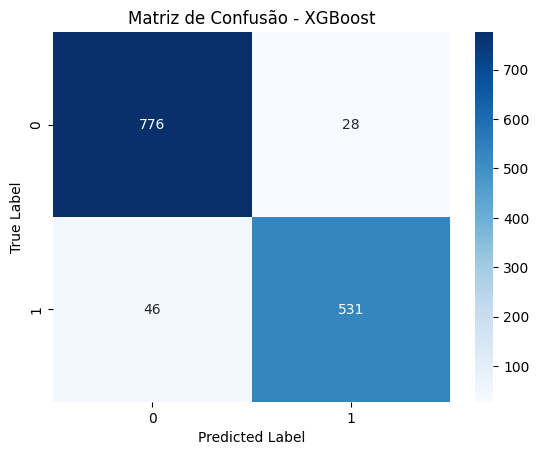

In [30]:

# Exemplo para o melhor modelo (substitua pelo modelo vencedor):
print("Plotando a Matriz de Confusão para XGBoost")
plot_confusion_matrix(y_test, y_pred_xgb, 'XGBoost')


Plotando a Matriz de Confusão para Lgb


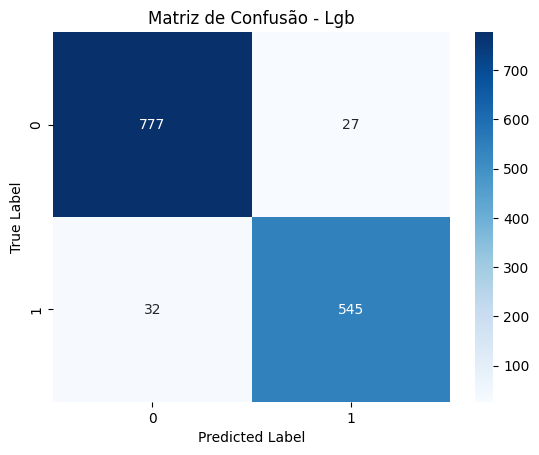

In [31]:
print("Plotando a Matriz de Confusão para Lgb")
plot_confusion_matrix(y_test, y_pred_lgb, 'Lgb')

Plotando a Matriz de Confusão para Cat


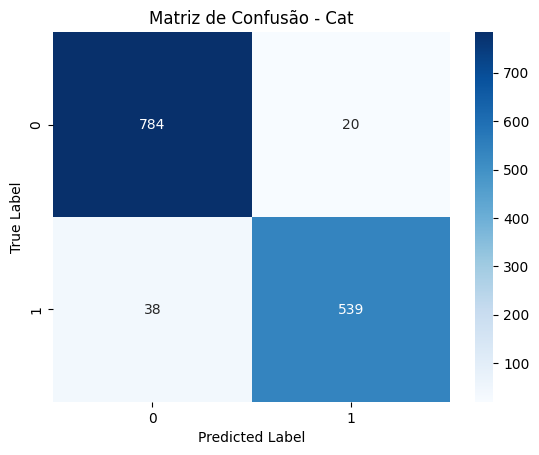

In [32]:
print("Plotando a Matriz de Confusão para Cat")
plot_confusion_matrix(y_test, y_pred_cat, 'Cat')

Plotando a Matriz de Confusão para GB


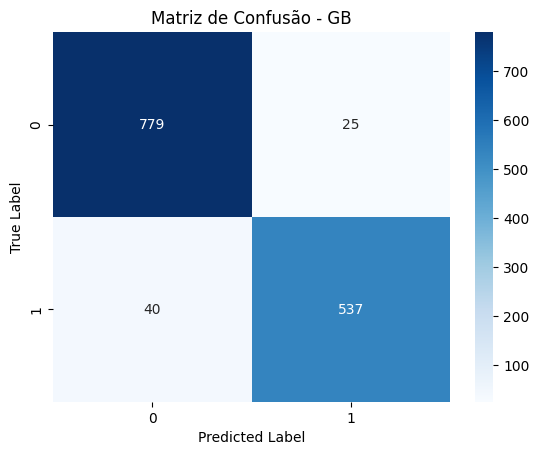

In [33]:
print("Plotando a Matriz de Confusão para GB")
plot_confusion_matrix(y_test, y_pred_gb, 'GB')

### Reapeated Kfold

In [46]:
cross_val_cancer_scores={}

XGBoost

In [53]:
model = TransformedTargetRegressor(XGBRFRegressor(objective='binary:logistic',**best_xgb ,nthread=1),
                                 transformer=MinMaxScaler(feature_range=(0,1)))

cv =RepeatedKFold(n_repeats=10,n_splits=10)
scoring =["neg_root_mean_squared_error","neg_mean_squared_error","r2"]

cross_val_cancer_scores["xgb"] =cross_validate(model,X,y,cv=cv,scoring=scoring)

In [54]:
print("Média")
print(pd.DataFrame(cross_val_cancer_scores["xgb"]).mean(axis=0))
print()
print("Desvio Padrão")
print(pd.DataFrame(cross_val_cancer_scores["xgb"]).std(axis=0))


Média
fit_time                            0.058153
score_time                          0.006032
test_neg_root_mean_squared_error   -0.849058
test_neg_mean_squared_error        -0.721481
test_r2                             0.052458
dtype: float64

Desvio Padrão
fit_time                            0.002161
score_time                          0.000541
test_neg_root_mean_squared_error    0.024233
test_neg_mean_squared_error         0.041025
test_r2                             0.003395
dtype: float64


In [55]:
model = TransformedTargetRegressor(LGBMRegressor(objective="binary",n_jobs=1,verbose=0,**best_lgb),
                                 transformer=MinMaxScaler(feature_range=(0,1)))

cv =RepeatedKFold(n_repeats=10,n_splits=10)

cross_val_cancer_scores["lgb"] =cross_validate(model,X,y,cv=cv,scoring=scoring)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [56]:
print("Média")
print(pd.DataFrame(cross_val_cancer_scores["lgb"]).mean(axis=0))
print()
print("Desvio Padrão")
print(pd.DataFrame(cross_val_cancer_scores["lgb"]).std(axis=0))

Média
fit_time                             0.056223
score_time                           0.004831
test_neg_root_mean_squared_error    -3.296917
test_neg_mean_squared_error        -10.870673
test_r2                            -13.324010
dtype: float64

Desvio Padrão
fit_time                            0.004254
score_time                          0.000712
test_neg_root_mean_squared_error    0.032002
test_neg_mean_squared_error         0.210982
test_r2                             0.840159
dtype: float64


In [57]:
model = TransformedTargetRegressor(CatBoostRegressor(logging_level="Silent",**best_cat),
                                 transformer=MinMaxScaler(feature_range=(0,1)))

cv =RepeatedKFold(n_repeats=10,n_splits=10)

cross_val_cancer_scores["cat"] =cross_validate(model,X,y,cv=cv,scoring=scoring)

In [58]:
print("Média")
print(pd.DataFrame(cross_val_cancer_scores["cat"]).mean(axis=0))
print()
print("Desvio Padrão")
print(pd.DataFrame(cross_val_cancer_scores["cat"]).std(axis=0))

Média
fit_time                            0.223330
score_time                          0.003891
test_neg_root_mean_squared_error   -0.671109
test_neg_mean_squared_error        -0.450836
test_r2                             0.407377
dtype: float64

Desvio Padrão
fit_time                            0.016887
score_time                          0.000864
test_neg_root_mean_squared_error    0.021280
test_neg_mean_squared_error         0.028492
test_r2                             0.028411
dtype: float64


In [59]:
model = TransformedTargetRegressor(GradientBoostingRegressor(**best_gb),
                                 transformer=MinMaxScaler(feature_range=(0,1)))

cv =RepeatedKFold(n_repeats=10,n_splits=10)


cross_val_cancer_scores["gb"] =cross_validate(model,X,y,cv=cv,scoring=scoring)

In [60]:
print("Média")
print(pd.DataFrame(cross_val_cancer_scores["gb"]).mean(axis=0))
print()
print("Desvio Padrão")
print(pd.DataFrame(cross_val_cancer_scores["gb"]).std(axis=0))

Média
fit_time                            1.047031
score_time                          0.004171
test_neg_root_mean_squared_error   -0.666104
test_neg_mean_squared_error        -0.444239
test_r2                             0.416378
dtype: float64

Desvio Padrão
fit_time                            0.019763
score_time                          0.000697
test_neg_root_mean_squared_error    0.023446
test_neg_mean_squared_error         0.031095
test_r2                             0.028328
dtype: float64


In [1]:
pd.DataFrame(cross_val_cancer_scores).shape

NameError: name 'pd' is not defined